# Similarity calculation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
from datasketch import MinHash, MinHashLSH
from tqdm import tqdm

## Dataset Preprocessing (Paula's part)

Load the dataset that Raquel processed (joining a few different datasets and adding the sentiment analysis)

In [2]:
main_complete = pd.read_csv('data/main_complete.csv')
main_complete_og = main_complete.copy()
main_complete.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,music_composer,imdb_rating,imdb_votes,poster_path,Netflix,Amazon,Hulu,Apple,HBO,sentiment
0,2,Ariel,7.1,330.0,Released,1988-10-21,0.0,73.0,0.0,tt0094675,...,NaN,7.4,8735.0,/ojDg0PGvs6R9xYFodRct2kdI6wC.jpg,0.0,1.0,1.0,0.0,0.0,68.24
1,3,Shadows in Paradise,7.3,369.0,Released,1986-10-17,0.0,74.0,0.0,tt0092149,...,NaN,7.5,7484.0,/nj01hspawPof0mJmlgfjuLyJuRN.jpg,0.0,1.0,1.0,0.0,0.0,73.44
2,5,Four Rooms,5.8,2623.0,Released,1995-12-09,4257354.0,98.0,4000000.0,tt0113101,...,Combustible Edison,6.7,112484.0,/75aHn1NOYXh4M7L5shoeQ6NGykP.jpg,0.0,1.0,0.0,1.0,0.0,86.06
3,6,Judgment Night,6.5,331.0,Released,1993-10-15,12136938.0,109.0,21000000.0,tt0107286,...,Alan Silvestri,6.6,19268.0,/3rvvpS9YPM5HB2f4HYiNiJVtdam.jpg,0.0,1.0,0.0,0.0,0.0,79.34
4,8,Life in Loops (A Megacities RMX),7.5,27.0,Released,2006-01-01,0.0,80.0,42000.0,tt0825671,...,NaN,8.2,284.0,/7ln81BRnPR2wqxuITZxEciCe1lc.jpg,0.0,0.0,0.0,0.0,0.0,382.44


To calculate the similarity, we need to do minhashing, that is why, a tokenization is first needed. We wanted to take several features for calculating the jaccard similarity:
- genre
- cast
- crew
- sentiment
- platforms (one-hot encoded)
- crew
- production companies
- production countries
- imbd votes
- imbd rating

To tokenize the features, we created sets for each of them with all the strings of each category inside

### Genres

In [3]:
# check how many movies have no genre
nulls = main_complete['genres'].isnull().sum()
print("This percentage of movies have no genre:", nulls/len(main_complete)*100, "%")

This percentage of movies have no genre: 29.076318106153554 %


In [4]:
# split the genres into a set of genres and remove spaces
main_complete['genres'] = main_complete['genres'].apply(lambda x: set(genre.strip() for genre in x.split(',')) if pd.notnull(x) else set())

We also did a small analysis of the genres to know with what we were working with

There are  19 different genres in the dataset
The genres are: {'Crime', 'History', 'Adventure', 'TV Movie', 'Mystery', 'Drama', 'Action', 'Documentary', 'Music', 'Thriller', 'Horror', 'Fantasy', 'Science Fiction', 'Comedy', 'Romance', 'War', 'Family', 'Animation', 'Western'}


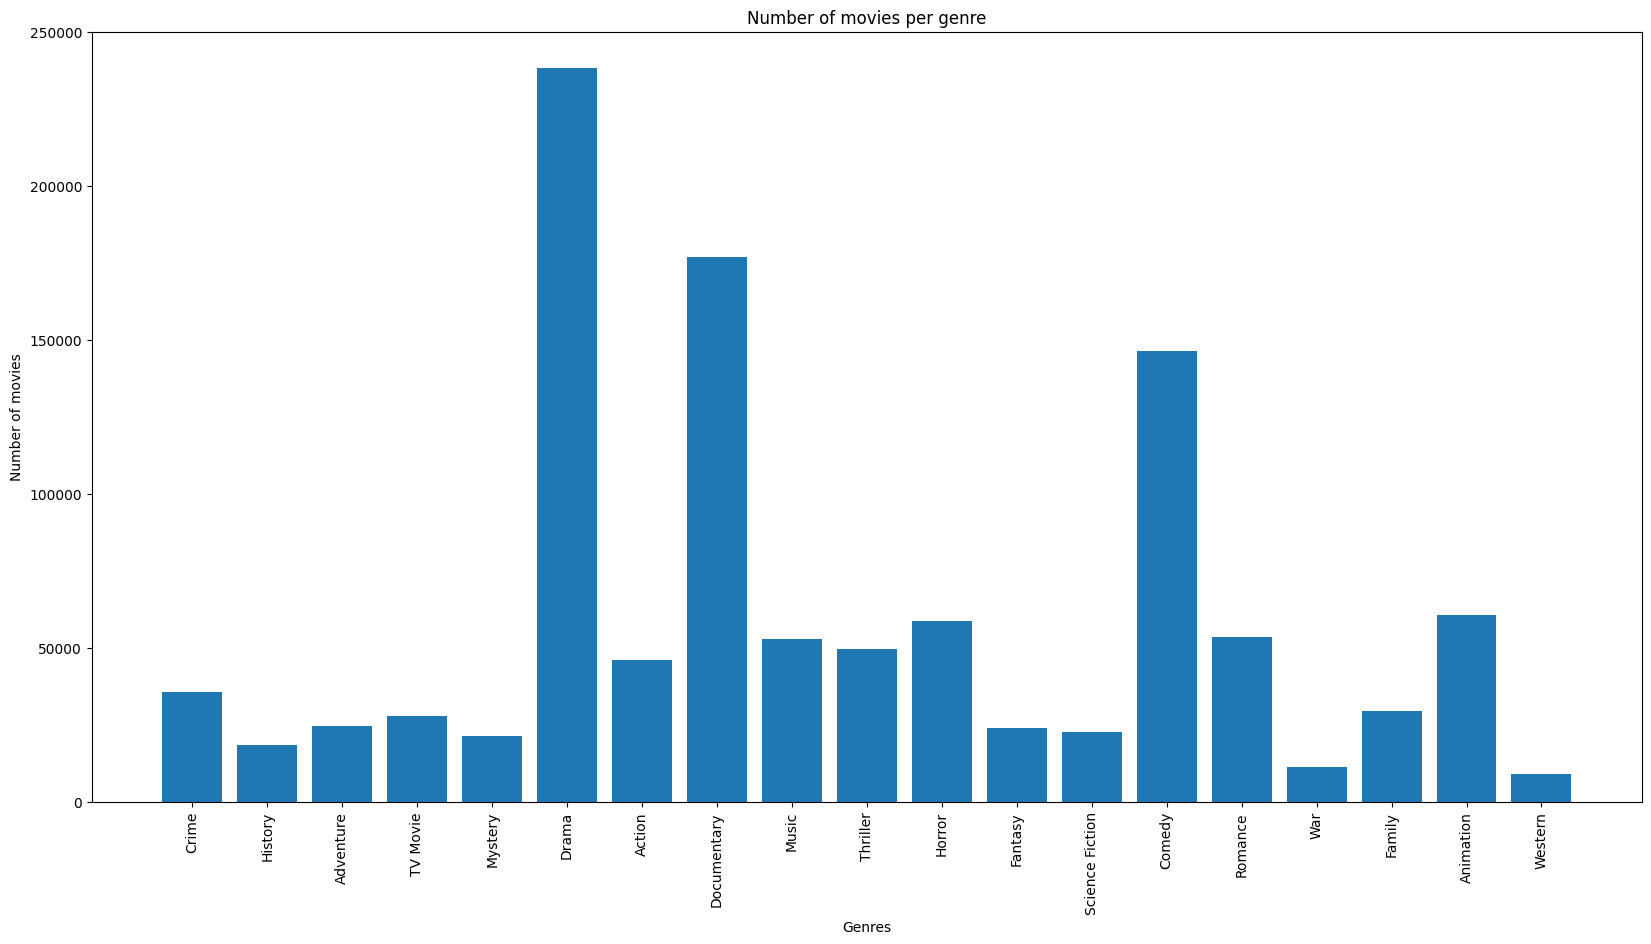

In [5]:
# check how many different genres are taking into account the content of the lists
genres = set()
for list in main_complete['genres']:
    # if list is not NaN
    if list is not np.nan:
        for genre in list:
            # remove the space at the beginning of the string if there is one
            genre = genre.strip()
            genres.add(genre)
print("There are ", len(genres), "different genres in the dataset")
print("The genres are:", genres)

genres_count = {genre: 0 for genre in genres}
for genre_list in main_complete['genres']:
    if genre_list is not np.nan:
        for genre in genre_list:
            genre = genre.strip()
            genres_count[genre] += 1

# histogram
plt.figure(figsize=(20, 10))
plt.bar(genres_count.keys(), genres_count.values())
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Number of movies')
plt.title('Number of movies per genre')
plt.show()

### Cast and crew

We reproduced the same procedure that we did for the genres. In this case, for the crew, we joined the columns of director and producers.

In [6]:
# split the cast into a set of cast and remove spaces
main_complete['cast'] = main_complete['cast'].apply(lambda x: set(actor.strip() for actor in x.split(',')) if pd.notnull(x) else set())

In [7]:
# how many movies have no cast
nulls = main_complete['cast'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no cast:", nulls/len(main_complete)*100, "%")

print(nulls)

This percentage of movies have no cast: 33.29124741666741 %
336188


After doing several tests with the code using different features, we decided to discard the 'cast' one because, since it is long, it has a big weight when calculating the similarities.

In [8]:
# remove the cast column
main_complete = main_complete.drop(columns=['cast'])

In [9]:
# Join the director and producers columns into a single column crew
columns_to_merge = ['director', 'producers']

for column in columns_to_merge:
    main_complete[column] = main_complete[column].apply(lambda x: set(person.strip() for person in x.split(',')) if pd.notnull(x) else set())

main_complete['crew'] = main_complete.apply(lambda row: set.union(row['director'], row['producers']), axis=1)

# Drop the individual columns
main_complete.drop(columns=columns_to_merge, inplace=True)

In [10]:
# how many movies have no crew
nulls = main_complete['crew'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no crew:", nulls/len(main_complete)*100, "%")

This percentage of movies have no crew: 17.2818637426362 %


### Production companies and countries

The same procedure was followed with these two features

In [11]:
# split the production_companies into a set and remove spaces
main_complete['production_companies'] = main_complete['production_companies'].apply(lambda x: set(company.strip() for company in x.split(',')) if pd.notnull(x) else set())
main_complete['production_companies'] = main_complete['production_companies'].apply(lambda x: x - {''})

In [12]:
# percentage of movies with no production companies
nulls = main_complete['production_companies'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no production companies:", nulls/len(main_complete)*100, "%")

This percentage of movies have no production companies: 53.91235632610743 %


In [13]:
main_complete['production_countries'] = main_complete['production_countries'].apply(lambda x: set(country.strip() for country in x.split(',')) if pd.notnull(x) else set())
main_complete['production_countries'] = main_complete['production_countries'].apply(lambda x: x - {''})

In [14]:
# percentage of movies with no production countries
nulls = main_complete['production_countries'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no production countries:", nulls/len(main_complete)*100, "%")

This percentage of movies have no production countries: 39.518774774988884 %


### Sentiment analysis

After calculating the sentiment for each movie, to take it into account for the minhashing, we decided to create three categories depending on the values. This was done due to the fact that dor this method, integers don't work as good as strings (TO REVIEW).

To find the thresholds we ...

In [15]:
sentiment_min = main_complete['sentiment'].min()
sentiment_max = main_complete['sentiment'].max()
sentiment_mean = main_complete['sentiment'].mean()
sentiment_std = main_complete['sentiment'].std()
sentiment_mid = main_complete['sentiment'].median()

print(f"Range of sentiment values: {sentiment_min} to {sentiment_max} with mean {sentiment_mean} and standard deviation {sentiment_std} and median {sentiment_mid}")

Range of sentiment values: 0.0 to 621.52 with mean 109.39746533773106 and standard deviation 83.97651422418457 and median 85.76


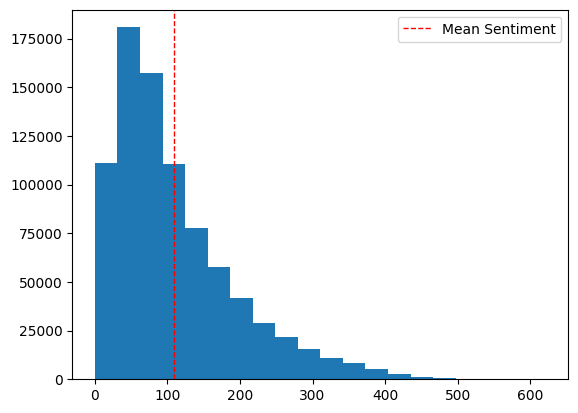

In [16]:
plt.hist(main_complete['sentiment'], bins=20)
plt.axvline(main_complete['sentiment'].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean Sentiment')
plt.legend()
plt.show()

In [17]:
# Define the thresholds for sentiment ranges
low_threshold = sentiment_mean - sentiment_std
high_threshold = sentiment_mean + sentiment_std

# Function to categorize sentiment
def categorize_sentiment(value):
    if value < low_threshold:
        return 'low'
    elif value > high_threshold:
        return 'high'
    else:
        return 'medium'

# Assuming main_complete is already defined and categorize_sentiment is a function
main_complete.loc[:, 'sentiment_category'] = main_complete['sentiment'].apply(categorize_sentiment)

# Display the updated dataframe
main_complete[['title', 'sentiment', 'sentiment_category']].head()

,title,sentiment,sentiment_category
0,Ariel,68.24,medium
1,Shadows in Paradise,73.44,medium
2,Four Rooms,86.06,medium
3,Judgment Night,79.34,medium
4,Life in Loops (A Megacities RMX),382.44,high


### Dataset cleaning

Finally, before doing the minhashing, some movies were deleted from the dataset because they had more than 4 interested features empty and because they were not "Released".

In [18]:
# clean movies with 3 or more interesting columns empty
columns = ['genres', 'crew', 'production_companies', 'production_countries', 'sentiment_category']

initial_count = len(main_complete)

# check each row if they have 3 or more columns from columns with empty sets
main_complete = main_complete[~(main_complete[columns].apply(lambda x: sum(1 for i in x if len(i) == 0) >= 4, axis=1))]
final_count = len(main_complete)

print("Number of movies removed: ", initial_count - final_count, "from a total of ", initial_count)
print("Percentage of movies removed: ", (initial_count - final_count) / initial_count * 100, "%")

Number of movies removed:  94569 from a total of  1009839
Percentage of movies removed:  9.364760125128857 %


In [19]:
# remove movies if the 'status' is not 'Released'
initial_count = len(main_complete)
main_complete = main_complete[main_complete['status'] == 'Released']
final_count = len(main_complete)

print("Number of movies removed: ", initial_count - final_count, "from a total of ", initial_count)
print("Percentage of movies removed: ", (initial_count - final_count) / initial_count * 100, "%")

Number of movies removed:  15995 from a total of  915270
Percentage of movies removed:  1.7475717547827416 %


Finally we saved the processed dataset so that we didn't have to run all the code everytime

## Minhashing

Load the small dataset that is the result of all the previous steps NOT SURE!!!
For some reason, when the dataset is loaded, the tokenization is lost and the similarity is not well calculated.

In [20]:
# prepare data for the minhashing, i just want to keep the columns: title, genre ones, sentiment, cast, crew, production_companies, production_countries and platform ones
data = main_complete[['id', 'title', 'genres', 'sentiment_category', 'Netflix', 'Amazon', 'Hulu', 'Apple', 'HBO', 'crew', 'production_companies', 'production_countries', 'imdb_votes', 'imdb_rating']]

In [ ]:
# data = main_complete.copy()

In [22]:
# load the small dataset
# data2 = pd.read_csv('data/small_main_complete.csv')

In [23]:
data.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,imdb_votes,poster_path,Netflix,Amazon,Hulu,Apple,HBO,sentiment,crew,sentiment_category
0,2,Ariel,7.1,330.0,Released,1988-10-21,0.0,73.0,0.0,tt0094675,...,8735.0,/ojDg0PGvs6R9xYFodRct2kdI6wC.jpg,0.0,1.0,1.0,0.0,0.0,68.24,{Aki Kaurismäki},medium
1,3,Shadows in Paradise,7.3,369.0,Released,1986-10-17,0.0,74.0,0.0,tt0092149,...,7484.0,/nj01hspawPof0mJmlgfjuLyJuRN.jpg,0.0,1.0,1.0,0.0,0.0,73.44,"{Mika Kaurismäki, Aki Kaurismäki}",medium
2,5,Four Rooms,5.8,2623.0,Released,1995-12-09,4257354.0,98.0,4000000.0,tt0113101,...,112484.0,/75aHn1NOYXh4M7L5shoeQ6NGykP.jpg,0.0,1.0,0.0,1.0,0.0,86.06,"{Alexandre Rockwell, Quentin Tarantino, Alliso...",medium
3,6,Judgment Night,6.5,331.0,Released,1993-10-15,12136938.0,109.0,21000000.0,tt0107286,...,19268.0,/3rvvpS9YPM5HB2f4HYiNiJVtdam.jpg,0.0,1.0,0.0,0.0,0.0,79.34,"{Gene Levy, Stephen Hopkins, Marilyn Vance, Ll...",medium
4,8,Life in Loops (A Megacities RMX),7.5,27.0,Released,2006-01-01,0.0,80.0,42000.0,tt0825671,...,284.0,/7ln81BRnPR2wqxuITZxEciCe1lc.jpg,0.0,0.0,0.0,0.0,0.0,382.44,"{Ulrich Gehmacher, Timo Novotny}",high


Create the minhashes for each row

In [24]:
# data2.head()

In [25]:
# Number of permutations for MinHash
num_perm = 128

# Function to create a combined MinHash for a movie
def create_combined_minhash(movie, one_hot_features, non_one_hot_features):
    m = MinHash(num_perm=num_perm)
    
    # Add one-hot encoded features
    for feature in one_hot_features:
        if movie[feature] == 1:
            m.update(feature.encode('utf8'))
    
    # Add non-one-hot encoded features
    for feature in non_one_hot_features:
        for token in movie[feature]:
            m.update(token.encode('utf8'))
    
    return m

In [26]:
# list of one-hot encoded features
one_hot_features = ['Netflix', 'Amazon', 'Hulu', 'Apple', 'HBO']

# list of non-one-hot encoded features
non_one_hot_features = ['genres', 'sentiment_category', 'crew', 'production_companies', 'production_countries']

We create the minhashes taking into account the desired features

In [27]:
minhashes = []
for idx, movie in tqdm(data.iterrows(), total=len(data), desc="Creating MinHashes"):
    minhash = create_combined_minhash(movie, one_hot_features, non_one_hot_features)
    minhashes.append(minhash)

Creating MinHashes: 100%|██████████| 899275/899275 [05:54<00:00, 2533.85it/s]


In [28]:
data['minhash'] = minhashes
data.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,poster_path,Netflix,Amazon,Hulu,Apple,HBO,sentiment,crew,sentiment_category,minhash
0,2,Ariel,7.1,330.0,Released,1988-10-21,0.0,73.0,0.0,tt0094675,...,/ojDg0PGvs6R9xYFodRct2kdI6wC.jpg,0.0,1.0,1.0,0.0,0.0,68.24,{Aki Kaurismäki},medium,<datasketch.minhash.MinHash object at 0x3e3b07...
1,3,Shadows in Paradise,7.3,369.0,Released,1986-10-17,0.0,74.0,0.0,tt0092149,...,/nj01hspawPof0mJmlgfjuLyJuRN.jpg,0.0,1.0,1.0,0.0,0.0,73.44,"{Mika Kaurismäki, Aki Kaurismäki}",medium,<datasketch.minhash.MinHash object at 0x3e3b07...
2,5,Four Rooms,5.8,2623.0,Released,1995-12-09,4257354.0,98.0,4000000.0,tt0113101,...,/75aHn1NOYXh4M7L5shoeQ6NGykP.jpg,0.0,1.0,0.0,1.0,0.0,86.06,"{Alexandre Rockwell, Quentin Tarantino, Alliso...",medium,<datasketch.minhash.MinHash object at 0x3e3b07...
3,6,Judgment Night,6.5,331.0,Released,1993-10-15,12136938.0,109.0,21000000.0,tt0107286,...,/3rvvpS9YPM5HB2f4HYiNiJVtdam.jpg,0.0,1.0,0.0,0.0,0.0,79.34,"{Gene Levy, Stephen Hopkins, Marilyn Vance, Ll...",medium,<datasketch.minhash.MinHash object at 0x3e3b07...
4,8,Life in Loops (A Megacities RMX),7.5,27.0,Released,2006-01-01,0.0,80.0,42000.0,tt0825671,...,/7ln81BRnPR2wqxuITZxEciCe1lc.jpg,0.0,0.0,0.0,0.0,0.0,382.44,"{Ulrich Gehmacher, Timo Novotny}",high,<datasketch.minhash.MinHash object at 0x3e3b07...


In order to be computational efficient, a function that interacts with the user is created so that the program calculates the jaccard similarity of all the movies with the one inputed by the user. The result of this function is a list of the 10th more similar movies.

THE MOVIE ID IS NOT WORKING PROPERLY, WE NEED TO INVESTIGATE WHY

In [29]:
def estimate_jaccard_similarity(data, minhashes, movie_title):
    # Find all movies with the specified title
    matching_movies = data[data['title'] == movie_title]

    if len(matching_movies) > 1:
        print(f"There are multiple movies with the title '{movie_title}'. Please choose one by its id:")
        for idx, row in matching_movies.iterrows():
            print(f"ID: {row['id']}, Crew: {row['crew']}")
        movie_id = int(input("Enter the movie id: "))
        movie_index = data[data['id'] == movie_id].index[0]
        print(f"Selected movie with id '{movie_id}' in position '{movie_index}'")
    elif len(matching_movies) == 1:
        movie_index = data[data['title'] == movie_title].index[0]
        print('movie_index:', movie_index)
        movie_id = data[data['title'] == movie_title]['id'].values[0]
        print(f"movie_id: {movie_id}")
    else:
        print(f"No movies found with the title '{movie_title}'")
        return []

    # Estimate Jaccard similarity with the specified movie
    print(f"Estimated Jaccard Similarity with '{movie_title}':")
    similarity_scores = []

    for i in tqdm(range(len(minhashes)), desc="Calculating Similarities"):
        if i != movie_index:
            similarity = data.iloc[movie_index]['minhash'].jaccard(data.iloc[i]['minhash'])
            similarity_scores.append((data.iloc[i]['title'], similarity, minhashes[i], data.iloc[i]['id']))

    # Sort the similarity scores in descending order
    similarity_scores.sort(key=lambda x: x[1], reverse=True)
    
    return similarity_scores, movie_id

In [30]:
# check the id and the iloc of The Hunger Games
data[data['title'] == 'The Hunger Games']

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,poster_path,Netflix,Amazon,Hulu,Apple,HBO,sentiment,crew,sentiment_category,minhash
49136,70160,The Hunger Games,7.2,21821.0,Released,2012-03-12,694394724.0,142.0,75000000.0,tt1392170,...,/yXCbOiVDCxO71zI7cuwBRXdftq8.jpg,1.0,1.0,0.0,1.0,1.0,326.3,"{Louise Rosner-Meyer, Suzanne Collins, Nina Ja...",high,<datasketch.minhash.MinHash object at 0x406052...


In [32]:
# ask the user to input a movie title
movie_title = input("Enter a movie title: ")

print('The movie title that you entered is:', movie_title)
# estimate the Jaccard similarity with the specified movie
similarity_scores, movie_id = estimate_jaccard_similarity(data, minhashes, movie_title)
print(movie_id)

The movie title that you entered is: Harry Potter and the Philosopher's Stone
movie_index: 541
movie_id: 671
Estimated Jaccard Similarity with 'Harry Potter and the Philosopher's Stone':


Calculating Similarities: 100%|██████████| 899275/899275 [01:19<00:00, 11331.33it/s]

671


In [33]:
similarity_scores[:10]

[('Harry Potter and the Chamber of Secrets',
  0.71875,
  np.int64(672)),
 ('Harry Potter and the Prisoner of Azkaban',
  0.6171875,
  np.int64(673)),
 ("Harry Potter and the Philosopher's Stone (Extended)",
  0.5703125,
  np.int64(1290195)),
 ('Monkeybone',
  0.5546875,
  np.int64(23685)),
 ('Night at the Museum',
  0.4921875,
  np.int64(1593)),
 ('The Christmas Chronicles',
  0.484375,
  np.int64(527435)),
 ('Night at the Museum: Kahmunrah Rises Again',
  0.4765625,
  np.int64(751741)),
 ('Percy Jackson & the Olympians: The Lightning Thief',
  0.46875,
  np.int64(32657)),
 ('Percy Jackson: Sea of Monsters',
  0.46875,
  np.int64(76285)),
 ('Valley of the Giants',
  0.46875,
  np.int64(174767))]

In [34]:
# Function to create a DataFrame with the top N similar movies
def create_top_n_dataframe(similarity_scores, data, movie_id, n=10):
    columns = ['title', 'crew', 'production_companies', 'production_countries', 'sentiment_category', 'Netflix', 'Amazon', 'Hulu', 'Apple', 'HBO']
    top_n_df = pd.DataFrame(columns=columns)
    top_n_list = []
    
    for movie, score, minhash, id in similarity_scores[:n]:
        movie_data = data[data['id'] == id]
        top_n_list.append(movie_data)

    top_n_list.append(data[data['id'] == movie_id])
    top_n_df = pd.concat(top_n_list)
    
    return top_n_df

# Create the DataFrame with the top 10 similar movies
top_10_df = create_top_n_dataframe(similarity_scores, data, movie_id, n=10)
top_10_df

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,poster_path,Netflix,Amazon,Hulu,Apple,HBO,sentiment,crew,sentiment_category,minhash
542,672,Harry Potter and the Chamber of Secrets,7.720,21818.0,Released,2002-11-13,876688482.0,161.0,100000000.0,tt0295297,...,/sdEOH0992YZ0QSxgXNIGLq1ToUi.jpg,1.0,1.0,1.0,0.0,1.0,160.45,"{David Barron, Chris Columbus, Michael Barnath...",medium,<datasketch.minhash.MinHash object at 0x3fcbeb...
543,673,Harry Potter and the Prisoner of Azkaban,8.018,21440.0,Released,2004-05-31,789804554.0,141.0,130000000.0,tt0304141,...,/aWxwnYoe8p2d2fcxOqtvAtJ72Rw.jpg,1.0,1.0,1.0,0.0,1.0,138.36,"{Tanya Seghatchian, Lorne Orleans, Chris Colum...",medium,<datasketch.minhash.MinHash object at 0x3fcbeb...
933332,1290195,Harry Potter and the Philosopher's Stone (Exte...,0.000,0.0,Released,NaN,976475550.0,0.0,125000000.0,NaN,...,NaN,0.0,0.0,0.0,0.0,0.0,NaN,{},medium,<datasketch.minhash.MinHash object at 0x4b9de0...
14003,23685,Monkeybone,5.100,318.0,Released,2001-02-23,5409517.0,93.0,75000000.0,tt0166276,...,/lgH7Wej9922C1MQv0wciAfesKH8.jpg,0.0,0.0,0.0,0.0,0.0,113.90,"{Lata Ryan, Chris Columbus, Sam Hamm, Michael ...",medium,<datasketch.minhash.MinHash object at 0x3fd919...
1042,1593,Night at the Museum,6.582,10092.0,Released,2006-12-20,574480841.0,108.0,110000000.0,tt0477347,...,/uY9k8t2FQkMj60obnAnsPKLxHCE.jpg,0.0,0.0,1.0,0.0,0.0,71.70,"{Mark Radcliffe, Thomas M. Hammel, Chris Colum...",medium,<datasketch.minhash.MinHash object at 0x3fcc1b...
367640,527435,The Christmas Chronicles,7.200,2116.0,Released,2018-11-22,0.0,104.0,0.0,tt2990140,...,/5Il2EMSF2KecrUKZPuen6BZmaCP.jpg,1.0,0.0,0.0,0.0,0.0,68.66,"{David Guggenheim, Chris Columbus, Clay Kaytis...",medium,<datasketch.minhash.MinHash object at 0x447508...
535608,751741,Night at the Museum: Kahmunrah Rises Again,6.500,252.0,Released,2022-12-08,0.0,77.0,0.0,tt13623880,...,/rEy4VFXn3fukXRhx8TnSZtOnlcm.jpg,0.0,0.0,0.0,0.0,0.0,98.18,"{Mark Radcliffe, Chris Columbus, Emily Morris,...",medium,<datasketch.minhash.MinHash object at 0x46aa14...
20528,32657,Percy Jackson & the Olympians: The Lightning T...,6.214,7362.0,Released,2010-02-01,226497209.0,118.0,95000000.0,tt0814255,...,NaN,1.0,1.0,0.0,0.0,0.0,101.15,"{Thomas M. Hammel, Chris Columbus, Michael Bar...",medium,<datasketch.minhash.MinHash object at 0x3fdb7d...
53668,76285,Percy Jackson: Sea of Monsters,6.000,5051.0,Released,2013-08-07,199850315.0,106.0,90000000.0,tt1854564,...,/tAu90qEpLqwqiZLsMqpaMVr55oN.jpg,1.0,1.0,0.0,0.0,0.0,61.84,"{Thor Freudenthal, Chris Columbus, Guy Oseary,...",medium,<datasketch.minhash.MinHash object at 0x406329...
104944,174767,Valley of the Giants,6.000,5.0,Released,1938-09-17,0.0,72.0,0.0,tt0030925,...,/qI3Kzi5vBxE2Ryui3iKicsFAalH.jpg,0.0,0.0,0.0,0.0,0.0,58.26,{William Keighley},medium,<datasketch.minhash.MinHash object at 0x411324...


In [ ]:
# check in data the movie with id 71766
data[data['id'] == 71766]

,id,title,genres,sentiment_category,Netflix,Amazon,Hulu,Apple,HBO,crew,production_companies,production_countries,imdb_votes,imdb_rating,minhash
50283,71766,On the Sunny Side of the Street,{Documentary},low,0.0,0.0,0.0,0.0,0.0,{Matjaž Klopčič},{Triglav film},{Yugoslavia},NaN,NaN,<datasketch.minhash.MinHash object at 0x42873c...


In [ ]:
# check the data with title 'The Hunger Games'
data[data['title'] == 'The Hunger Games']

,id,title,genres,sentiment_category,Netflix,Amazon,Hulu,Apple,HBO,crew,production_companies,production_countries,imdb_votes,imdb_rating,minhash
49136,70160,The Hunger Games,"{Adventure, Fantasy, Science Fiction}",high,1.0,1.0,0.0,1.0,1.0,"{Suzanne Collins, Louise Rosner-Meyer, Robin B...","{Lionsgate, Color Force}",{United States of America},1021720.0,7.2,<datasketch.minhash.MinHash object at 0x4286cc...
